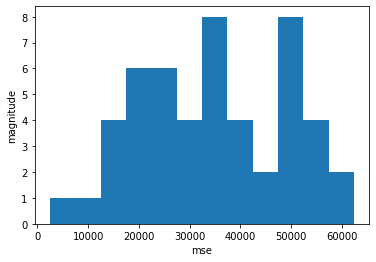

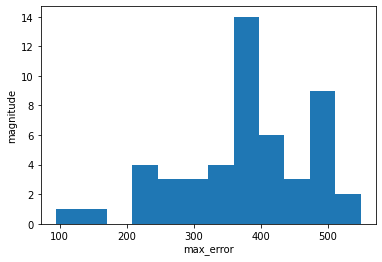

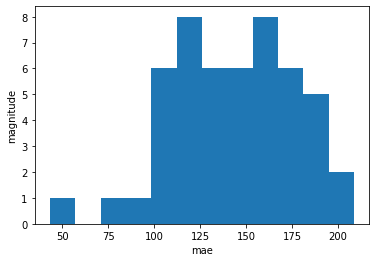

In [7]:
import warnings
warnings.filterwarnings('ignore')
from randomizer_ml.trainer import EvaluateModel
from randomizer_ml.experiment import Experiment
from randomizer_ml.visualizer import Visualizer
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow_addons.losses import pinball_loss
import tensorflow as tf
import matplotlib.pyplot as plt

class NeuralNet(Model):
    def __init__(self, X_in, X_out, optimizer):
        super(NeuralNet, self).__init__()
        self.hidden_layer = Dense(X_in, activation="linear")
        self.hidden_layer2 = Dense(X_in, activation="linear")
        self.final_layer = Dense(X_out, activation="linear")
        self.optimizer = optimizer
        self.hyperparameters = {}

    def call(self, x):
        x = x.values
        res = self.hidden_layer(x)
        res = self.hidden_layer2(res)
        return self.final_layer(res)

    def step(self, x, y):
        y = y.values
        #x = tf.cast(x, tf.float64)
        #y = tf.cast(y, tf.float64)
        with tf.GradientTape() as tape:
            pred = self.call(x)
            loss = pinball_loss(y, pred, 0.5)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def fit(self, x, y, num_steps=2000):
        for step in range(num_steps):
            nn.step(x, y)
           
    def predict(self, x):
        return self.call(x)
   
    def get_coefs(self):
        weights = self.get_weights()
        self.coef_ = weights[0].dot(weights[2]).dot(weights[4])
       
    def get_params(self):
        return {}

# data MUST be pandas dataframe and series respectively
# honest-ml makes use of the indices of the data, which numpy does
# not maintain
X, y = make_regression()
X = pd.DataFrame(X)
y = pd.Series(y)

# num_trails should be something like 200
# this is not the case because I'm impatient 
# (and this is just an example)
with Experiment("quantile_regression3") as experiment:
    num_trials = 50 
    learning_rate = 0.0001
    optimizer = tf.optimizers.Adam(learning_rate)
    nn = NeuralNet(X.shape[1], 1, optimizer)
    reg_eval = EvaluateModel("regression", nn, X, y, num_trials)
    model_instances = reg_eval.fit_random("random")
    experiment.log_model_instances(model_instances)
    experiment.log_model(nn)
    experiment.log_num_trials(num_trials)

viz = Visualizer(
    model_instances,
    "regression",
    coef_names=X.columns.tolist(),
    output_dir="experiments/quantile_regression2/"
)
viz.visualize_regression(
    bins=len(model_instances)//4,
    show_plot=True,
    save_plots=True,
    formatting="png"
)